`Indexes` can be a difficult concept to grasp at first.
I suspect this is partly becuase they're somewhat peculiar to pandas.
These aren't like the indexes put on relational database tables for performance optimizations.
Rather, they're more like the `row_labels` of an R DataFrame, but much more capable.

`Indexes` offer

- metadata container
- easy label-based row selection
- easy label-based alignment in operations
- label-based concatenation

To demonstrate these, we'll first fetch some more data.
This will be weather data from sensors at a bunch of airports across the US.
See [here](https://github.com/akrherz/iem/blob/master/scripts/asos/iem_scraper_example.py) for the example scraper I based this off of.

In [3]:
%matplotlib inline

import json
import glob
import datetime
from io import StringIO

import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('ticks')

# States are broken into networks. The networks have a list of ids, each representing a station.
# We will take that list of ids and pass them as query parameters to the URL we built up ealier.
states = """AK AL AR AZ CA CO CT DE FL GA HI IA ID IL IN KS KY LA MA MD ME
 MI MN MO MS MT NC ND NE NH NJ NM NV NY OH OK OR PA RI SC SD TN TX UT VA VT
 WA WI WV WY""".split()

# IEM has Iowa AWOS sites in its own labeled network
networks = ['AWOS'] + ['{}_ASOS'.format(state) for state in states]

In [4]:
def get_weather(stations, start=pd.Timestamp('2014-01-01'),
                end=pd.Timestamp('2014-01-31')):
    '''
    Fetch weather data from MESONet between ``start`` and ``stop``.
    '''
    url = ("http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"
           "&data=tmpf&data=relh&data=sped&data=mslp&data=p01i&data=vsby&data=gust_mph&data=skyc1&data=skyc2&data=skyc3"
           "&tz=Etc/UTC&format=comma&latlon=no"
           "&{start:year1=%Y&month1=%m&day1=%d}"
           "&{end:year2=%Y&month2=%m&day2=%d}&{stations}")
    stations = "&".join("station=%s" % s for s in stations)
    weather = (pd.read_csv(url.format(start=start, end=end, stations=stations),
                           comment="#")
                 .rename(columns={"valid": "date"})
                 .rename(columns=str.strip)
                 .assign(date=lambda df: pd.to_datetime(df['date']))
                 .set_index(["station", "date"])
                 .sort_index())
    float_cols = ['tmpf', 'relh', 'sped', 'mslp', 'p01i', 'vsby', "gust_mph"]
    weather[float_cols] = weather[float_cols].apply(pd.to_numeric, errors="corce")
    return weather

In [5]:
def get_ids(network):
    url = "http://mesonet.agron.iastate.edu/geojson/network.php?network={}"
    r = requests.get(url.format(network))
    md = pd.io.json.json_normalize(r.json()['features'])
    md['network'] = network
    return md

Talk briefly about the gem of a method that is `json_normalize`.

In [6]:
url = "http://mesonet.agron.iastate.edu/geojson/network.php?network={}"
r = requests.get(url.format("AWOS"))
js = r.json()

In [7]:
js['features'][:2]

[{'geometry': {'coordinates': [-94.2723694444, 43.0796472222],
   'type': 'Point'},
  'id': 'AXA',
  'properties': {'sid': 'AXA', 'sname': 'ALGONA'},
  'type': 'Feature'},
 {'geometry': {'coordinates': [-93.569475, 41.6878083333], 'type': 'Point'},
  'id': 'IKV',
  'properties': {'sid': 'IKV', 'sname': 'ANKENY'},
  'type': 'Feature'}]

In [8]:
pd.DataFrame(js['features']).head()

,geometry,id,properties,type
0,"{'type': 'Point', 'coordinates': [-94.27236944...",AXA,"{'sname': 'ALGONA', 'sid': 'AXA'}",Feature
1,"{'type': 'Point', 'coordinates': [-93.569475, ...",IKV,"{'sname': 'ANKENY', 'sid': 'IKV'}",Feature
2,"{'type': 'Point', 'coordinates': [-95.04652777...",AIO,"{'sname': 'ATLANTIC', 'sid': 'AIO'}",Feature
3,"{'type': 'Point', 'coordinates': [-94.92044166...",ADU,"{'sname': 'AUDUBON', 'sid': 'ADU'}",Feature
4,"{'type': 'Point', 'coordinates': [-93.848575, ...",BNW,"{'sname': 'BOONE MUNI', 'sid': 'BNW'}",Feature


In [9]:
js['features'][0]

{'geometry': {'coordinates': [-94.2723694444, 43.0796472222], 'type': 'Point'},
 'id': 'AXA',
 'properties': {'sid': 'AXA', 'sname': 'ALGONA'},
 'type': 'Feature'}

In [11]:
stations = pd.io.json.json_normalize(js['features']).id
url = ("http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"
       "&data=tmpf&data=relh&data=sped&data=mslp&data=p01i&data=vsby&data=gust_mph&data=skyc1&data=skyc2&data=skyc3"
       "&tz=Etc/UTC&format=comma&latlon=no"
       "&{start:year1=%Y&month1=%m&day1=%d}"
       "&{end:year2=%Y&month2=%m&day2=%d}&{stations}")
stations = "&".join("station=%s" % s for s in stations)
start = pd.Timestamp('2014-01-01')
end=pd.Timestamp('2014-01-31')

weather = (pd.read_csv(url.format(start=start, end=end, stations=stations),
                       comment="#"))

In [42]:
import os
# ids = pd.concat([get_ids(network) for network in networks], ignore_index=True)
gr = ids.groupby('network')

os.makedirs("weather", exist_ok=True)

for i, (k, v) in enumerate(gr):
    print("{}/{}".format(i, len(networks), end='\r'))
    weather = get_weather(v['id'])
    weather.to_csv("weather/{}.csv".format(k))

weather = pd.concat([
    pd.read_csv(f, parse_dates='date', index_col=['station', 'date'])
    for f in glob.glob('weather/*.csv')
]).sort_index()

weather.to_hdf("weather.h5", "weather")

0/51
1/51
2/51
3/51
4/51
5/51
6/51
7/51
8/51
9/51
10/51
11/51
12/51
13/51
14/51
15/51
16/51
17/51
18/51
19/51
20/51
21/51
22/51
23/51


/Users/tom.augspurger/Envs/blog/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


24/51
25/51
26/51
27/51
28/51
29/51


RemoteDisconnected: Remote end closed connection without response

In [18]:
weather.set_index(['station', 'valid']).sort_index().to_hdf("weather.h5", "weather")

In [37]:
weather

tmpf    relh    sped    mslp     p01i    vsby   \
station valid                                                              
ADU     2014-01-01 00:05  10.40   72.12    13.7       M      0.0   10.00   
        2014-01-01 00:15  10.40   72.12    12.5       M      0.0   10.00   
        2014-01-01 00:25  10.40   72.12    13.7       M      0.0   10.00   
        2014-01-01 00:35  10.40   72.12    12.5       M      0.0   10.00   
        2014-01-01 00:45  10.40   72.12    12.5       M      0.0   10.00   
...                         ...     ...     ...     ...      ...     ...   
VTI     2014-01-30 23:30  19.58   71.42     6.8       M      0.0   10.00   
        2014-01-30 23:35  19.40   73.13     8.0       M      0.0   10.00   
        2014-01-30 23:40  19.40   74.30     9.1       M      0.0   10.00   
        2014-01-30 23:50  19.40   74.89     9.1       M      0.0   10.00   
        2014-01-30 23:55  19.40   75.49     8.0       M      0.0   10.00   

                           gust_mph    skyc1    skyc2    skyc3  
station valid                                                   
ADU     2014-01-01 00:05           M      SCT        M       M  
        2014-01-01 00:15           M      SCT        M       M  
        2014-01-01 00:25        20.5      CLR        M       M  
        2014-01-01 00:35        20.5      SCT        M       M  
        2014-01-01 00:45        17.1      SCT        M       M  
...                              ...      ...      ...     ...  
VTI     2014-01-30 23:30        17.1      CLR        M       M  
        2014-01-30 23:35           M      CLR        M       M  
        2014-01-30 23:40           M      CLR        M       M  
        2014-01-30 23:50           M      CLR        M       M  
        2014-01-30 23:55           M      SCT        M       M  

[259086 rows x 10 columns]

In [28]:
weather.index.get_level_values(0).value_counts()

AXA    6344
SHL    6344
DNS    6339
MXO    6329
OLZ    6328
       ... 
OOA    4655
VTI    4505
FXY    4261
FOD    2158
CWI    2135
Name: station, dtype: int64

In [19]:
weather = pd.read_hdf("weather.h5", "weather").sort_index()

weather.head()

tmpf    relh    sped    mslp     p01i    vsby   \
station valid                                                              
ADU     2014-01-01 00:05  10.40   72.12    13.7       M      0.0   10.00   
        2014-01-01 00:15  10.40   72.12    12.5       M      0.0   10.00   
        2014-01-01 00:25  10.40   72.12    13.7       M      0.0   10.00   
        2014-01-01 00:35  10.40   72.12    12.5       M      0.0   10.00   
        2014-01-01 00:45  10.40   72.12    12.5       M      0.0   10.00   

                           gust_mph    skyc1    skyc2    skyc3  
station valid                                                   
ADU     2014-01-01 00:05           M      SCT        M       M  
        2014-01-01 00:15           M      SCT        M       M  
        2014-01-01 00:25        20.5      CLR        M       M  
        2014-01-01 00:35        20.5      SCT        M       M  
        2014-01-01 00:45        17.1      SCT        M       M

OK, that was a bit of work. Here's a plot to reward ourselves.

In [33]:
weather

tmpf    relh    sped    mslp     p01i    vsby   \
station valid                                                              
ADU     2014-01-01 00:05  10.40   72.12    13.7       M      0.0   10.00   
        2014-01-01 00:15  10.40   72.12    12.5       M      0.0   10.00   
        2014-01-01 00:25  10.40   72.12    13.7       M      0.0   10.00   
        2014-01-01 00:35  10.40   72.12    12.5       M      0.0   10.00   
        2014-01-01 00:45  10.40   72.12    12.5       M      0.0   10.00   
...                         ...     ...     ...     ...      ...     ...   
VTI     2014-01-30 23:30  19.58   71.42     6.8       M      0.0   10.00   
        2014-01-30 23:35  19.40   73.13     8.0       M      0.0   10.00   
        2014-01-30 23:40  19.40   74.30     9.1       M      0.0   10.00   
        2014-01-30 23:50  19.40   74.89     9.1       M      0.0   10.00   
        2014-01-30 23:55  19.40   75.49     8.0       M      0.0   10.00   

                           gust_mph    skyc1    skyc2    skyc3  
station valid                                                   
ADU     2014-01-01 00:05           M      SCT        M       M  
        2014-01-01 00:15           M      SCT        M       M  
        2014-01-01 00:25        20.5      CLR        M       M  
        2014-01-01 00:35        20.5      SCT        M       M  
        2014-01-01 00:45        17.1      SCT        M       M  
...                              ...      ...      ...     ...  
VTI     2014-01-30 23:30        17.1      CLR        M       M  
        2014-01-30 23:35           M      CLR        M       M  
        2014-01-30 23:40           M      CLR        M       M  
        2014-01-30 23:50           M      CLR        M       M  
        2014-01-30 23:55           M      SCT        M       M  

[259086 rows x 10 columns]

KeyError: "['sped' 'gust_mph'] not in index"

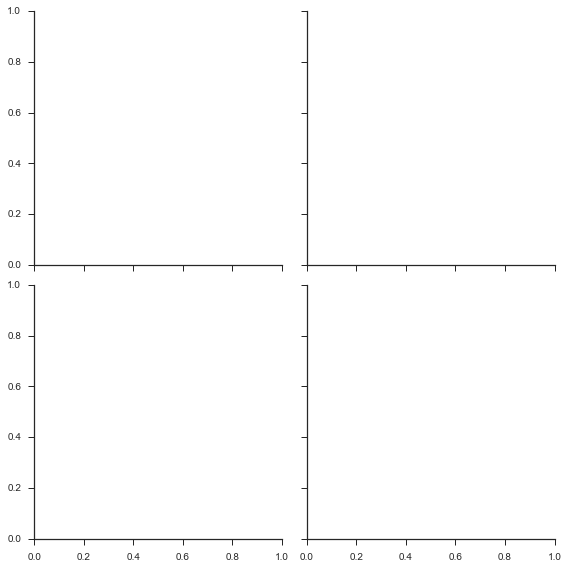

In [32]:
airports = ['AXA', 'SHL', 'DNS', 'MXO']

g = sns.FacetGrid(weather.loc[airports].reset_index(),
                  col='station', hue='station', col_wrap=2, size=4)
g.map(sns.regplot, 'sped', 'gust_mph')

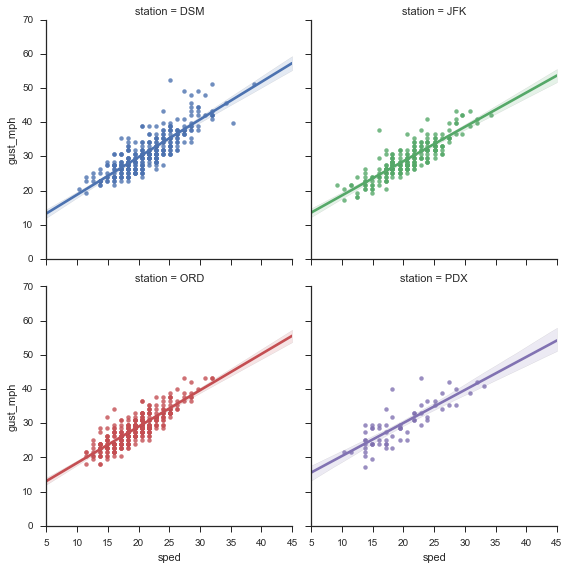

In [8]:
airports = ['DSM', 'ORD', 'JFK', 'PDX']

g = sns.FacetGrid(weather.sort_index().loc[airports].reset_index(),
                  col='station', hue='station', col_wrap=2, size=4)
g.map(sns.regplot, 'sped', 'gust_mph')
plt.savefig('../content/images/indexes_wind_gust_facet.svg', transparent=True);

# Set Operations

Indexes are set-like (technically *multi*sets, since you can have duplicates), so they support most python `set` operations. Indexes are immutable so you won't find any of the inplace `set` operations.
One other difference is that since `Index`es are also array like, you can't use some infix operators like `-` for `difference`. If you have a numeric index it is unclear whether you intend to perform math operations or set operations.
You can use `&` for intersetion, `|` for union, and `^` for symmetric difference though, since there's no ambiguity.

For example, lets find the set of airports that we have weather and flight information on. Since `weather` had a MultiIndex of `airport,datetime`, we'll use the `levels` attribute to get at the airport data, separate from the date data.

In [3]:
# Bring in the flights data

flights = pd.read_hdf('flights.h5', 'flights')

weather_locs = weather.index.levels[0]
# The `categories` attribute of a Categorical is an Index
origin_locs = flights.origin.cat.categories
dest_locs = flights.dest.cat.categories

airports = weather_locs & origin_locs & dest_locs
airports

Index(['ABE', 'ABI', 'ABQ', 'ABR', 'ABY', 'ACT', 'ACV', 'AEX', 'AGS', 'ALB',
       ...
       'TUL', 'TUS', 'TVC', 'TWF', 'TXK', 'TYR', 'TYS', 'VLD', 'VPS', 'XNA'],
      dtype='object', length=267)

In [8]:
print("Weather, no flights:\n\t", weather_locs.difference(origin_locs | dest_locs), end='\n\n')

print("Flights, no weather:\n\t", (origin_locs | dest_locs).difference(weather_locs), end='\n\n')

print("Dropped Stations:\n\t", (origin_locs | dest_locs) ^ weather_locs)

Weather, no flights:
	 Index(['01M', '04V', '04W', '05U', '06D', '08D', '0A9', '0CO', '0E0', '0F2',
       ...
       'Y50', 'Y51', 'Y63', 'Y70', 'YIP', 'YKM', 'YKN', 'YNG', 'ZPH', 'ZZV'],
      dtype='object', length=1909)

Flights, no weather:
	 Index(['ADK', 'ADQ', 'ANC', 'BET', 'BKG', 'BQN', 'BRW', 'CDV', 'CLD', 'FAI',
       'FCA', 'GUM', 'HNL', 'ITO', 'JNU', 'KOA', 'KTN', 'LIH', 'MQT', 'OGG',
       'OME', 'OTZ', 'PPG', 'PSE', 'PSG', 'SCC', 'SCE', 'SIT', 'SJU', 'STT',
       'STX', 'WRG', 'YAK', 'YUM'],
      dtype='object')

Dropped Stations:
	 Index(['01M', '04V', '04W', '05U', '06D', '08D', '0A9', '0CO', '0E0', '0F2',
       ...
       'Y63', 'Y70', 'YAK', 'YIP', 'YKM', 'YKN', 'YNG', 'YUM', 'ZPH', 'ZZV'],
      dtype='object', length=1943)


# Flavors

Pandas has many subclasses of the regular `Index`, each tailored to a specific kind of data.
Most of the time these will be created for you automatically, so you don't have to worry about which one to choose.

1. [`Index`](http://pandas.pydata.org/pandas-docs/version/0.18.0/generated/pandas.Index.html#pandas.Index)
2. `Int64Index`
3. `RangeIndex` (Memory-saving special case of `Int64Index`)
4. `FloatIndex`
5. `DatetimeIndex`: Datetime64[ns] precision data
6. `PeriodIndex`: Regularly-spaced, arbitrary precision datetime data.
7. `TimedeltaIndex`: Timedelta data
8. `CategoricalIndex`:

Some of these are purely optimizations, others use information about the data to provide additional methods.
And while sometimes you might work with indexes directly (like the set operations above), most of they time you'll be operating on a Series or DataFrame, which in turn makes use of its Index.

### Row Slicing
We saw in part one that they're great for making *row* subsetting as easy as column subsetting.

In [9]:
weather.loc['DSM'].head()

,tmpf,relh,sped,mslp,p01i,vsby,gust_mph,skyc1,skyc2,skyc3
date,,,,,,,,,,
2014-01-01 00:54:00,10.94,72.79,10.3,1024.9,0.0,10.0,NaN,FEW,M,M
2014-01-01 01:54:00,10.94,72.79,11.4,1025.4,0.0,10.0,NaN,OVC,M,M
2014-01-01 02:54:00,10.94,72.79,8.0,1025.3,0.0,10.0,NaN,BKN,M,M
2014-01-01 03:54:00,10.94,72.79,9.1,1025.3,0.0,10.0,NaN,OVC,M,M
2014-01-01 04:54:00,10.04,72.69,9.1,1024.7,0.0,10.0,NaN,BKN,M,M


Without indexes we'd probably resort to boolean masks.

In [10]:
weather2 = weather.reset_index()
weather2[weather2['station'] == 'DSM'].head()

,station,date,tmpf,relh,sped,mslp,p01i,vsby,gust_mph,skyc1,skyc2,skyc3
884855,DSM,2014-01-01 00:54:00,10.94,72.79,10.3,1024.9,0.0,10.0,NaN,FEW,M,M
884856,DSM,2014-01-01 01:54:00,10.94,72.79,11.4,1025.4,0.0,10.0,NaN,OVC,M,M
884857,DSM,2014-01-01 02:54:00,10.94,72.79,8.0,1025.3,0.0,10.0,NaN,BKN,M,M
884858,DSM,2014-01-01 03:54:00,10.94,72.79,9.1,1025.3,0.0,10.0,NaN,OVC,M,M
884859,DSM,2014-01-01 04:54:00,10.04,72.69,9.1,1024.7,0.0,10.0,NaN,BKN,M,M


Slightly less convenient, but still doable.

### Indexes for Easier Arithmetic, Analysis

It's nice to have your metadata (labels on each observation) next to you actual values. But if you store them in an array, they'll get in the way. Say we wanted to translate the farenheit temperature to celcius.

In [116]:
# With indecies
temp = weather['tmpf']

c = (temp - 32) * 5 / 9
c.to_frame()

tmpf
station date                     
01M     2014-01-01 00:15:00   1.0
        2014-01-01 00:35:00   0.8
        2014-01-01 00:55:00   0.3
        2014-01-01 01:15:00  -0.1
        2014-01-01 01:35:00   0.0
...                           ...
ZZV     2014-01-30 19:53:00  -2.8
        2014-01-30 20:53:00  -2.2
        2014-01-30 21:53:00  -2.2
        2014-01-30 22:53:00  -2.8
        2014-01-30 23:53:00  -1.7

[3303647 rows x 1 columns]

In [13]:
# without
temp2 = weather.reset_index()[['station', 'date', 'tmpf']]

temp2['tmpf'] = (temp2['tmpf'] - 32) * 5 / 9
temp2.head()

,station,date,tmpf
0,01M,2014-01-01 00:15:00,1.0
1,01M,2014-01-01 00:35:00,0.8
2,01M,2014-01-01 00:55:00,0.3
3,01M,2014-01-01 01:15:00,-0.1
4,01M,2014-01-01 01:35:00,0.0


Again, not terrible, but not as good.
And, what if you had wanted to keep farenheit around as well, instead of overwriting it like we did?
Then you'd need to make a copy of everything, including the `station` and `date` columns.
We don't have that problem, since indexes are mutable and safely shared between DataFrames / Series.

In [14]:
temp.index is c.index

True

### Indexes for Alignment

I've saved the best for last.
Automatic alignment, or reindexing, is fundamental to pandas.

All binary operations (add, multiply, etc...) between Series/DataFrames first *align* and then proceed.

Let's suppose we have hourly observations on temperature and windspeed.
And suppose some of the observations were invalid, and not reported (simulated below by sampling from the full dataset). We'll assume the missing windspeed observations were potentially different from the missing temperature observations.

In [124]:
dsm = weather.loc['DSM']

hourly = dsm.resample('H').mean()

temp = hourly['tmpf'].sample(frac=.5, random_state=1).sort_index()
sped = hourly['sped'].sample(frac=.5, random_state=2).sort_index()

In [125]:
temp.head().to_frame()

,tmpf
date,
2014-01-01 00:00:00,10.94
2014-01-01 02:00:00,10.94
2014-01-01 03:00:00,10.94
2014-01-01 04:00:00,10.04
2014-01-01 05:00:00,10.04


In [126]:
sped.head()

date
2014-01-01 01:00:00    11.4
2014-01-01 02:00:00     8.0
2014-01-01 03:00:00     9.1
2014-01-01 04:00:00     9.1
2014-01-01 05:00:00    10.3
Name: sped, dtype: float64

Notice that the two indexes aren't identical.

Suppose that the `windspeed : temperature` ratio is meaningful.
When we go to compute that, pandas will automatically align the two by index label.

In [129]:
sped / temp

date
2014-01-01 00:00:00         NaN
2014-01-01 01:00:00         NaN
2014-01-01 02:00:00    0.731261
2014-01-01 03:00:00    0.831810
2014-01-01 04:00:00    0.906375
                         ...   
2014-01-30 13:00:00         NaN
2014-01-30 14:00:00    0.584712
2014-01-30 17:00:00         NaN
2014-01-30 21:00:00         NaN
2014-01-30 23:00:00         NaN
dtype: float64

This lets you focus on doing the operation, rather than manually aligning things, ensuring that the arrays are the same length and in the same order.
By deault, missing values are inserted where the two don't align.
You can use the method version of any binary operation to specify a `fill_value`

In [130]:
sped.div(temp, fill_value=1)

date
2014-01-01 00:00:00     0.091408
2014-01-01 01:00:00    11.400000
2014-01-01 02:00:00     0.731261
2014-01-01 03:00:00     0.831810
2014-01-01 04:00:00     0.906375
                         ...    
2014-01-30 13:00:00     0.027809
2014-01-30 14:00:00     0.584712
2014-01-30 17:00:00     0.023267
2014-01-30 21:00:00     0.035663
2014-01-30 23:00:00    13.700000
dtype: float64

And since I couldn't find anywhere else to put it, you can control the axis the operation is aligned along as well.

In [131]:
hourly.div(sped, axis='index')

,tmpf,relh,sped,mslp,p01i,vsby,gust_mph
date,,,,,,,
2014-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 01:00:00,0.959649,6.385088,1.0,89.947368,0.0,0.877193,NaN
2014-01-01 02:00:00,1.367500,9.098750,1.0,128.162500,0.0,1.250000,NaN
2014-01-01 03:00:00,1.202198,7.998901,1.0,112.670330,0.0,1.098901,NaN
2014-01-01 04:00:00,1.103297,7.987912,1.0,112.604396,0.0,1.098901,NaN
...,...,...,...,...,...,...,...
2014-01-30 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-30 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-30 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The non row-labeled version of this is messy.

In [132]:
temp2 = temp.reset_index()
sped2 = sped.reset_index()

# Find rows where the operation is defined
common_dates = pd.Index(temp2.date) & sped2.date
pd.concat([
    # concat to not lose date information
    sped2.loc[sped2['date'].isin(common_dates), 'date'],
    (sped2.loc[sped2.date.isin(common_dates), 'sped'] /
     temp2.loc[temp2.date.isin(common_dates), 'tmpf'])],
    axis=1).dropna(how='all')

,date,0
1,2014-01-01 02:00:00,0.731261
2,2014-01-01 03:00:00,0.831810
3,2014-01-01 04:00:00,0.906375
4,2014-01-01 05:00:00,1.025896
8,2014-01-01 13:00:00,NaN
...,...,...
351,2014-01-29 23:00:00,0.535609
354,2014-01-30 05:00:00,0.487735
356,2014-01-30 09:00:00,NaN
357,2014-01-30 10:00:00,0.618939


Yeah, I prefer the `temp / sped` version.

Alignment isn't limited to arithmetic operations, although those are the most obvious and easiest to demonstrate.

# Merging

There are two ways of merging DataFrames / Series in pandas

1. Relational Database style with `pd.merge`
2. Array style with `pd.concat`

Personally, I think in terms of the `concat` style.
I learned pandas before I ever really used SQL, so it comes more naturally to me I suppose.
`pd.merge` has more flexibilty, though I think *most* of the time you don't need this flexibilty.

### Concat Version

In [133]:
pd.concat([temp, sped], axis=1).head()

,tmpf,sped
date,,
2014-01-01 00:00:00,10.94,NaN
2014-01-01 01:00:00,NaN,11.4
2014-01-01 02:00:00,10.94,8.0
2014-01-01 03:00:00,10.94,9.1
2014-01-01 04:00:00,10.04,9.1


The `axis` parameter controls how the data should be stacked, `0` for vertically, `1` for horizontally.
The `join` parameter controls the merge behavior on the shared axis, (the Index for `axis=1`). By default it's like a union of the two indexes, or an outer join.

In [134]:
pd.concat([temp, sped], axis=1, join='inner')

,tmpf,sped
date,,
2014-01-01 02:00:00,10.94,8.000
2014-01-01 03:00:00,10.94,9.100
2014-01-01 04:00:00,10.04,9.100
2014-01-01 05:00:00,10.04,10.300
2014-01-01 13:00:00,8.96,13.675
...,...,...
2014-01-29 23:00:00,35.96,18.200
2014-01-30 05:00:00,33.98,17.100
2014-01-30 09:00:00,35.06,16.000


### Merge Version

Since we're joining by index here the merge version is quite similar.
We'll see an example later of a one-to-many join where the two differ.

In [41]:
pd.merge(temp.to_frame(), sped.to_frame(), left_index=True, right_index=True).head()

,tmpf,sped
date,,
2014-01-01 02:00:00,10.94,8.000
2014-01-01 03:00:00,10.94,9.100
2014-01-01 04:00:00,10.04,9.100
2014-01-01 05:00:00,10.04,10.300
2014-01-01 13:00:00,8.96,13.675


In [42]:
pd.merge(temp.to_frame(), sped.to_frame(), left_index=True, right_index=True,
         how='outer').head()

,tmpf,sped
date,,
2014-01-01 00:00:00,10.94,NaN
2014-01-01 01:00:00,NaN,11.4
2014-01-01 02:00:00,10.94,8.0
2014-01-01 03:00:00,10.94,9.1
2014-01-01 04:00:00,10.04,9.1


Like I said, I typically prefer `concat` to `merge`.
The exception here is one-to-many type joins. Let's walk through one of those,
where we join the flight data to the weather data.
To focus just on the merge, we'll aggregate hour weather data to be daily, rather than trying to find the closest recorded weather observation to each departure (you could do that, but it's not the focus right now). We'll then join the one `(airport, date)` record to the many `(airport, date, flight)` records.

Quick tangent, to get the weather data to daily frequency, we'll need to resample (more on that in the timeseries section). The resample essentially involves breaking the recorded values into daily buckets and computing the aggregation function on each bucket. The only wrinkle is that we have to resample *by station*, so we'll use the `pd.TimeGrouper` helper.

In [43]:
idx_cols = ['unique_carrier', 'origin', 'dest', 'tail_num', 'fl_num', 'fl_date']
data_cols = ['crs_dep_time', 'dep_delay', 'crs_arr_time', 'arr_delay',
             'taxi_out', 'taxi_in', 'wheels_off', 'wheels_on', 'distance']

df = flights.set_index(idx_cols)[data_cols].sort_index()

In [64]:
def mode(x):
    '''
    Arbitrarily break ties.
    '''
    return x.value_counts().index[0]

aggfuncs = {'tmpf': 'mean', 'relh': 'mean',
            'sped': 'mean', 'mslp': 'mean',
            'p01i': 'mean', 'vsby': 'mean',
            'gust_mph': 'mean', 'skyc1': mode,
            'skyc2': mode, 'skyc3': mode}
# TimeGrouper works on a DatetimeIndex, so we move `station` to the
# columns and then groupby it as well.
daily = (weather.reset_index(level="station")
                .groupby([pd.TimeGrouper('1d'), "station"])
                .agg(aggfuncs))

daily.head()

gust_mph       vsby       sped       relh skyc1  \
date       station                                                     
2014-01-01 01M            NaN   9.229167   2.262500  81.117917   CLR   
           04V      31.307143   9.861111  11.131944  72.697778   CLR   
           04W            NaN  10.000000   3.601389  69.908056   OVC   
           05U            NaN   9.929577   3.770423  71.519859   CLR   
           06D            NaN   9.576389   5.279167  73.784179   CLR   

                         tmpf skyc2  mslp  p01i skyc3  
date       station                                     
2014-01-01 01M      35.747500     M   NaN   0.0     M  
           04V      18.350000     M   NaN   0.0     M  
           04W      -9.075000     M   NaN   0.0     M  
           05U      26.321127     M   NaN   0.0     M  
           06D     -11.388060     M   NaN   0.0     M

### The merge version

In [110]:
m = pd.merge(flights, daily.reset_index().rename(columns={'date': 'fl_date', 'station': 'origin'}),
             on=['fl_date', 'origin']).set_index(idx_cols).sort_index()

m.head()

airline_id  \
unique_carrier origin dest tail_num fl_num fl_date                  
AA             ABQ    DFW  N200AA   1090   2014-01-27       19805   
                                    1662   2014-01-06       19805   
                           N202AA   1332   2014-01-27       19805   
                           N426AA   1467   2014-01-15       19805   
                                    1662   2014-01-09       19805   

                                                       origin_airport_id  \
unique_carrier origin dest tail_num fl_num fl_date                         
AA             ABQ    DFW  N200AA   1090   2014-01-27              10140   
                                    1662   2014-01-06              10140   
                           N202AA   1332   2014-01-27              10140   
                           N426AA   1467   2014-01-15              10140   
                                    1662   2014-01-09              10140   

                                                       origin_airport_seq_id  \
unique_carrier origin dest tail_num fl_num fl_date                             
AA             ABQ    DFW  N200AA   1090   2014-01-27                1014002   
                                    1662   2014-01-06                1014002   
                           N202AA   1332   2014-01-27                1014002   
                           N426AA   1467   2014-01-15                1014002   
                                    1662   2014-01-09                1014002   

                                                       origin_city_market_id  \
unique_carrier origin dest tail_num fl_num fl_date                             
AA             ABQ    DFW  N200AA   1090   2014-01-27                  30140   
                                    1662   2014-01-06                  30140   
                           N202AA   1332   2014-01-27                  30140   
                           N426AA   1467   2014-01-15                  30140   
                                    1662   2014-01-09                  30140   

                                                      origin_city_name  \
unique_carrier origin dest tail_num fl_num fl_date                       
AA             ABQ    DFW  N200AA   1090   2014-01-27  Albuquerque, NM   
                                    1662   2014-01-06  Albuquerque, NM   
                           N202AA   1332   2014-01-27  Albuquerque, NM   
                           N426AA   1467   2014-01-15  Albuquerque, NM   
                                    1662   2014-01-09  Albuquerque, NM   

                                                      origin_state_nm  \
unique_carrier origin dest tail_num fl_num fl_date                      
AA             ABQ    DFW  N200AA   1090   2014-01-27      New Mexico   
                                    1662   2014-01-06      New Mexico   
                           N202AA   1332   2014-01-27      New Mexico   
                           N426AA   1467   2014-01-15      New Mexico   
                                    1662   2014-01-09      New Mexico   

                                                       dest_airport_id  \
unique_carrier origin dest tail_num fl_num fl_date                       
AA             ABQ    DFW  N200AA   1090   2014-01-27            11298   
                                    1662   2014-01-06            11298   
                           N202AA   1332   2014-01-27            11298   
                           N426AA   1467   2014-01-15            11298   
                                    1662   2014-01-09            11298   

                                                       dest_airport_seq_id  \
unique_carrier origin dest tail_num fl_num fl_date                           
AA             ABQ    DFW  N200AA   1090   2014-01-27              1129803   
                                    1662   2014-01-06              1129803   
                           N202AA   1332   2014-01-27 

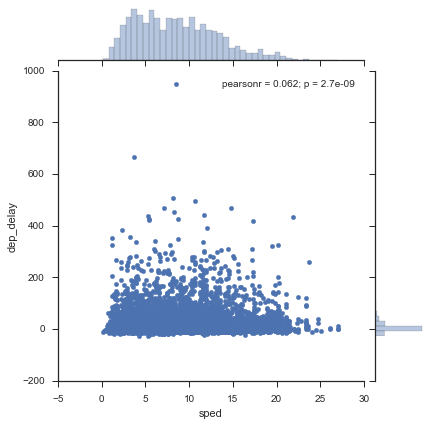

In [135]:
m.sample(n=10000).pipe((sns.jointplot, 'data'), 'sped', 'dep_delay')
plt.savefig('../content/images/indexes_sped_delay_join.svg', transparent=True)

In [136]:
m.groupby('skyc1').dep_delay.agg(['mean', 'count']).sort_values(by='mean')

,mean,count
skyc1,,
M,-1.948052,77
CLR,11.222288,115121
FEW,16.863177,161727
SCT,17.803048,19289
BKN,18.638034,54030
OVC,21.667762,52643
VV,30.487008,9583


In [137]:
import statsmodels.api as sm

In [203]:
mod = sm.OLS.from_formula('dep_delay ~ C(skyc1) + distance + tmpf + relh + sped + mslp', data=m)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dep_delay   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     976.4
Date:                Sun, 10 Apr 2016   Prob (F-statistic):               0.00
Time:                        16:06:15   Log-Likelihood:            -2.1453e+06
No. Observations:              410372   AIC:                         4.291e+06
Df Residuals:                  410360   BIC:                         4.291e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept        -331.1032     10.828    -30.577      0.000      -352.327  -309.880
C(skyc1)[T.CLR]    -4.4041      0.249    -17.662      0.000        -4.893    -3.915
C(skyc1)[T.FEW]    -0.7330      0.226     -3.240      0.001        -1.176    -0.290
C(skyc1)[T.M]     -16.4341      8.681     -1.893      0.058       -33.448     0.580
C(skyc1)[T.OVC]     0.3818      0.281      1.358      0.174        -0.169     0.933
C(skyc1)[T.SCT]     0.8589      0.380      2.260      0.024         0.114     1.604
C(skyc1)[T.VV ]     8.8603      0.509     17.414      0.000         7.863     9.858
distance            0.0008      0.000      6.174      0.000         0.001     0.001
tmpf               -0.1841      0.005    -38.390      0.000        -0.193    -0.175
relh                0.1626      0.004     38.268      0.000         0.154     0.171
sped                0.6096      0.018     33.716      0.000         0.574     0.645
mslp                0.3340      0.010     31.960      0.000         0.313     0.354
==============================================================================
Omnibus:                   456713.147   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         76162962.824
Skew:                           5.535   Prob(JB):                         0.00
Kurtosis:                      68.816   Cond. No.                     2.07e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.07e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

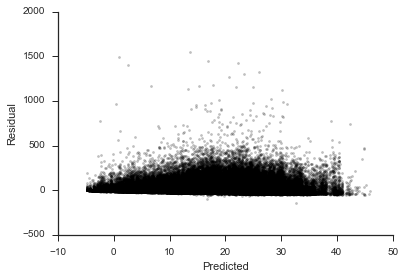

In [206]:
fig, ax = plt.subplots()
ax.scatter(res.fittedvalues, res.resid, color='k', marker='.', alpha=.25)
ax.set(xlabel='Predicted', ylabel='Residual')
sns.despine()
plt.savefig('../content/images/indexes_resid_fit.png', transparent=True)

In [4]:
weather.head()

tmpf   relh  sped  mslp  p01i  vsby  gust_mph  \
station date                                                                  
01M     2014-01-01 00:15:00  33.80  85.86   0.0   NaN   0.0  10.0       NaN   
        2014-01-01 00:35:00  33.44  87.11   0.0   NaN   0.0  10.0       NaN   
        2014-01-01 00:55:00  32.54  90.97   0.0   NaN   0.0  10.0       NaN   
        2014-01-01 01:15:00  31.82  93.65   0.0   NaN   0.0  10.0       NaN   
        2014-01-01 01:35:00  32.00  92.97   0.0   NaN   0.0  10.0       NaN   

                            skyc1 skyc2 skyc3  
station date                                   
01M     2014-01-01 00:15:00   CLR     M     M  
        2014-01-01 00:35:00   CLR     M     M  
        2014-01-01 00:55:00   CLR     M     M  
        2014-01-01 01:15:00   CLR     M     M  
        2014-01-01 01:35:00   CLR     M     M

In [77]:
import numpy as np
import pandas as pd


def read(fp):
    df = (pd.read_csv(fp)
            .rename(columns=str.lower)
            .drop('unnamed: 36', axis=1)
            .pipe(extract_city_name)
            .pipe(time_to_datetime, ['dep_time', 'arr_time', 'crs_arr_time', 'crs_dep_time'])
            .assign(fl_date=lambda x: pd.to_datetime(x['fl_date']),
                    dest=lambda x: pd.Categorical(x['dest']),
                    origin=lambda x: pd.Categorical(x['origin']),
                    tail_num=lambda x: pd.Categorical(x['tail_num']),
                    unique_carrier=lambda x: pd.Categorical(x['unique_carrier']),
                    cancellation_code=lambda x: pd.Categorical(x['cancellation_code'])))
    return df

def extract_city_name(df):
    '''
    Chicago, IL -> Chicago for origin_city_name and dest_city_name
    '''
    cols = ['origin_city_name', 'dest_city_name']
    city = df[cols].apply(lambda x: x.str.extract("(.*), \w{2}", expand=False))
    df = df.copy()
    df[['origin_city_name', 'dest_city_name']] = city
    return df

def time_to_datetime(df, columns):
    '''
    Combine all time items into datetimes.
    
    2014-01-01,0914 -> 2014-01-01 09:14:00
    '''
    df = df.copy()
    def converter(col):
        timepart = (col.astype(str)
                       .str.replace('\.0$', '')  # NaNs force float dtype
                       .str.pad(4, fillchar='0'))
        return  pd.to_datetime(df['fl_date'] + ' ' +
                               timepart.str.slice(0, 2) + ':' +
                               timepart.str.slice(2, 4),
                               errors='coerce')
        return datetime_part
    df[columns] = df[columns].apply(converter)
    return df


flights = read("878167309_T_ONTIME.csv")

In [80]:
locs = weather.index.levels[0] & flights.origin.unique()

In [76]:
(weather.reset_index(level='station')
 .query('station in @locs')
 .groupby(['station', pd.TimeGrouper('H')])).mean()

tmpf   relh  sped    mslp  p01i  vsby  gust_mph
station date                                                                 
ABE     2014-01-01 00:00:00  26.06  47.82  14.8  1024.4   0.0  10.0      21.7
        2014-01-01 01:00:00  24.08  51.93   8.0  1025.2   0.0  10.0       NaN
        2014-01-01 02:00:00  24.08  49.87   6.8  1025.7   0.0  10.0       NaN
        2014-01-01 03:00:00  23.00  52.18   9.1  1026.2   0.0  10.0       NaN
        2014-01-01 04:00:00  23.00  52.18   4.6  1026.4   0.0  10.0       NaN
...                            ...    ...   ...     ...   ...   ...       ...
XNA     2014-01-30 19:00:00  44.96  38.23  16.0  1009.7   0.0  10.0      25.1
        2014-01-30 20:00:00  46.04  41.74  16.0  1010.3   0.0  10.0       NaN
        2014-01-30 21:00:00  46.04  41.74  13.7  1010.9   0.0  10.0      20.5
        2014-01-30 22:00:00  42.98  46.91  11.4  1011.5   0.0  10.0       NaN
        2014-01-30 23:00:00  39.92  54.81   3.4  1012.2   0.0  10.0       NaN

[191445 rows x 7 columns]

In [82]:
df = (flights.copy()[['unique_carrier', 'tail_num', 'origin', 'dep_time']]
      .query('origin in @locs'))

In [55]:
weather.loc['DSM']

,tmpf,relh,sped,mslp,p01i,vsby,gust_mph,skyc1,skyc2,skyc3
date,,,,,,,,,,
2014-01-01 00:54:00,10.94,72.79,10.3,1024.9,0.0,10.0,NaN,FEW,M,M
2014-01-01 01:54:00,10.94,72.79,11.4,1025.4,0.0,10.0,NaN,OVC,M,M
2014-01-01 02:54:00,10.94,72.79,8.0,1025.3,0.0,10.0,NaN,BKN,M,M
2014-01-01 03:54:00,10.94,72.79,9.1,1025.3,0.0,10.0,NaN,OVC,M,M
2014-01-01 04:54:00,10.04,72.69,9.1,1024.7,0.0,10.0,NaN,BKN,M,M
...,...,...,...,...,...,...,...,...,...,...
2014-01-30 19:54:00,30.92,55.99,28.5,1006.3,0.0,10.0,35.3,FEW,FEW,M
2014-01-30 20:54:00,30.02,55.42,14.8,1008.4,0.0,10.0,28.5,FEW,FEW,M
2014-01-30 21:54:00,28.04,55.12,18.2,1010.4,0.0,10.0,26.2,FEW,FEW,M


In [49]:
df = df

,fl_date,unique_carrier,airline_id,tail_num,fl_num,origin_airport_id,origin_airport_seq_id,origin_city_market_id,origin,origin_city_name,...,arr_delay,cancelled,cancellation_code,diverted,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2014-01-01,AA,19805,N338AA,1,12478,1247802,31703,JFK,New York,...,13.0,0.0,NaN,0.0,2475.0,NaN,NaN,NaN,NaN,NaN
1,2014-01-01,AA,19805,N339AA,2,12892,1289203,32575,LAX,Los Angeles,...,111.0,0.0,NaN,0.0,2475.0,111.0,0.0,0.0,0.0,0.0
2,2014-01-01,AA,19805,N335AA,3,12478,1247802,31703,JFK,New York,...,13.0,0.0,NaN,0.0,2475.0,NaN,NaN,NaN,NaN,NaN
3,2014-01-01,AA,19805,N367AA,5,11298,1129803,30194,DFW,Dallas/Fort Worth,...,1.0,0.0,NaN,0.0,3784.0,NaN,NaN,NaN,NaN,NaN
4,2014-01-01,AA,19805,N364AA,6,13830,1383002,33830,OGG,Kahului,...,-8.0,0.0,NaN,0.0,3711.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471944,2014-01-31,OO,20304,N292SW,5313,12889,1288903,32211,LAS,Las Vegas,...,-7.0,0.0,NaN,0.0,259.0,NaN,NaN,NaN,NaN,NaN
471945,2014-01-31,OO,20304,N580SW,5314,12892,1289203,32575,LAX,Los Angeles,...,-12.0,0.0,NaN,0.0,89.0,NaN,NaN,NaN,NaN,NaN
471946,2014-01-31,OO,20304,N580SW,5314,14689,1468902,34689,SBA,Santa Barbara,...,11.0,0.0,NaN,0.0,89.0,NaN,NaN,NaN,NaN,NaN
471947,2014-01-31,OO,20304,N216SW,5315,11292,1129202,30325,DEN,Denver,...,56.0,0.0,NaN,0.0,260.0,36.0,0.0,13.0,0.0,7.0


In [47]:
dep.head()

0        2014-01-01 09:14:00
1        2014-01-01 11:32:00
2        2014-01-01 11:57:00
3        2014-01-01 13:07:00
4        2014-01-01 17:53:00
                 ...        
163906   2014-01-11 16:57:00
163910   2014-01-11 11:04:00
181062   2014-01-12 17:02:00
199092   2014-01-13 23:36:00
239150   2014-01-16 16:46:00
Name: dep_time, dtype: datetime64[ns]

In [39]:
flights.dep_time

0        2014-01-01 09:14:00
1        2014-01-01 11:32:00
2        2014-01-01 11:57:00
3        2014-01-01 13:07:00
4        2014-01-01 17:53:00
                 ...        
471944   2014-01-31 09:05:00
471945   2014-01-31 09:24:00
471946   2014-01-31 10:39:00
471947   2014-01-31 09:28:00
471948   2014-01-31 11:22:00
Name: dep_time, dtype: datetime64[ns]

In [25]:
flights.dep_time.unique()

array(['2014-01-01T03:14:00.000000000-0600',
       '2014-01-01T05:32:00.000000000-0600',
       '2014-01-01T05:57:00.000000000-0600', ...,
       '2014-01-30T18:44:00.000000000-0600',
       '2014-01-31T17:16:00.000000000-0600',
       '2014-01-30T18:47:00.000000000-0600'], dtype='datetime64[ns]')

In [ ]:
stations

In [9]:
flights.dep_time.head()

0   2014-01-01 09:14:00
1   2014-01-01 11:32:00
2   2014-01-01 11:57:00
3   2014-01-01 13:07:00
4   2014-01-01 17:53:00
Name: dep_time, dtype: datetime64[ns]